In [4]:
#configuración en google colab de spark y pyspark
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4
! pip install --ignore-installed -q spark-nlp==2.7.1

openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)
     |████████████████████████████████| 215.7MB 60kB/s 
     |████████████████████████████████| 204kB 17.7MB/s 
     |████████████████████████████████| 143kB 4.4MB/s 


In [6]:
import sparknlp 
spark = sparknlp.start()
sc = spark.sparkContext

In [63]:
from pyspark.ml.feature import Tokenizer as TokenizerML
from pyspark.ml.feature import StopWordsRemover, NGram
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, Word2Vec,\
                               Word2VecModel, IDFModel, CountVectorizerModel

from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,
                                LemmatizerModel, Stemmer, StopWordsCleaner)
from pyspark.ml import Pipeline

from pyspark.sql.functions import udf, explode, count, collect_list, \
                                  regexp_replace, col, lower, array_remove
import re

In [8]:
# directorios (path) de entrada y salida:
path_in="gdrive/My Drive/datasets/papers_sample_pdf/"
path_out="gdrive/My Drive/datasets/out/"
filenametxt_in='in.txt'
filenametxt_out='out.txt'
filenamecsv_in='in.csv'
filenamecsv_out='out.csv'

# Create functions to print results

In [9]:
# Dummy dataset to show how works the function explode and the group by to count the words
dummy_df=spark.createDataFrame([(1,'I really liked this movie'),
                         (2,'I would recommend this movie to my friends'),
                         (3,'movie was alright but acting was horrible'),
                         (4,'I am never watching that movie ever again')],
                        ['user_id','content'])
# Tokenize dummy dataframe
tokenizationML=TokenizerML(inputCol='content', outputCol='tokens')
dummy_tokenized_df=tokenizationML.transform(dummy_df)
dummy_tokenized_df.show(5, False)

+-------+------------------------------------------+---------------------------------------------------+
|user_id|content                                   |tokens                                             |
+-------+------------------------------------------+---------------------------------------------------+
|1      |I really liked this movie                 |[i, really, liked, this, movie]                    |
|2      |I would recommend this movie to my friends|[i, would, recommend, this, movie, to, my, friends]|
|3      |movie was alright but acting was horrible |[movie, was, alright, but, acting, was, horrible]  |
|4      |I am never watching that movie ever again |[i, am, never, watching, that, movie, ever, again] |
+-------+------------------------------------------+---------------------------------------------------+



In [10]:
dummy_tokenized_df.withColumn("word", explode("tokens")).select("tokens", "word").show(10, 40)

+----------------------------------------+---------+
|                                  tokens|     word|
+----------------------------------------+---------+
|         [i, really, liked, this, movie]|        i|
|         [i, really, liked, this, movie]|   really|
|         [i, really, liked, this, movie]|    liked|
|         [i, really, liked, this, movie]|     this|
|         [i, really, liked, this, movie]|    movie|
|[i, would, recommend, this, movie, to...|        i|
|[i, would, recommend, this, movie, to...|    would|
|[i, would, recommend, this, movie, to...|recommend|
|[i, would, recommend, this, movie, to...|     this|
|[i, would, recommend, this, movie, to...|    movie|
+----------------------------------------+---------+
only showing top 10 rows



In [11]:
dummy_tokenized_df.withColumn("word", explode("tokens")) \
              .select("word") \
              .groupBy('word') \
              .agg(count('word')\
              .alias('count')).orderBy('count', ascending=False)\
              .show(10)            

+--------+-----+
|    word|count|
+--------+-----+
|   movie|    4|
|       i|    3|
|     was|    2|
|    this|    2|
| friends|    1|
|   again|    1|
|   liked|    1|
|watching|    1|
|  acting|    1|
|     but|    1|
+--------+-----+
only showing top 10 rows



In [12]:
import matplotlib
import matplotlib.pyplot as plt

def plot_word_count(df, nameColumn):
  count_words = df.withColumn("word", explode(nameColumn)) \
              .select("word") \
              .groupBy('word') \
              .agg(count('word')\
              .alias('count')).orderBy('count', ascending=False) \
              .limit(20) \
              .toPandas()

  plt.figure(figsize=(15,5))     
  plt.xticks(rotation=90)       
  plt.bar(count_words["word"], count_words["count"])
  plt.show()

In [13]:
count_vec=CountVectorizer(inputCol='tokens', outputCol='features')
cv_df=count_vec.fit(dummy_tokenized_df).transform(dummy_tokenized_df)
cv_df.select(['tokens','features']).show(4,False)
bow = count_vec.fit(dummy_tokenized_df).vocabulary
print(bow)
len(bow)

+---------------------------------------------------+-------------------------------------------------------------+
|tokens                                             |features                                                     |
+---------------------------------------------------+-------------------------------------------------------------+
|[i, really, liked, this, movie]                    |(21,[0,1,3,5,10],[1.0,1.0,1.0,1.0,1.0])                      |
|[i, would, recommend, this, movie, to, my, friends]|(21,[0,1,3,6,7,14,15,19],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |
|[movie, was, alright, but, acting, was, horrible]  |(21,[0,2,4,9,13,20],[1.0,2.0,1.0,1.0,1.0,1.0])               |
|[i, am, never, watching, that, movie, ever, again] |(21,[0,1,8,11,12,16,17,18],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------------------+-------------------------------------------------------------+

['movie', 'i', 'this', 'was', 'recommend', 'am', 'ever', 'again', 'neve

21

In [14]:
def print_size_bow(df, name_column, print_bow=True):
  count_vec=CountVectorizer(inputCol=name_column, outputCol='features')
  cv_df=count_vec.fit(df).transform(df)
  cv_df.select([name_column,'features']).show(5, 50)
  bow = count_vec.fit(df).vocabulary
  if print_bow: print(bow)
  print(len(bow))

# Process corpus

In [15]:
rdd_files_txt = sc.wholeTextFiles(path_in + "*.txt")
rdd_files_xml = sc.wholeTextFiles(path_in + "*.xml")
rdd_files = rdd_files_txt.union(rdd_files_xml)
files_df = rdd_files.toDF(schema=['path','content'])

base_name_udf = udf(lambda path: os.path.basename(path))

files_df = files_df.withColumn("filename", base_name_udf(files_df.path))\
  .select("filename", "content")

files_df.limit(10).toPandas()

filename                                            content
0  0704.3504.txt  Smooth Rényi Entropy of Ergodic Quantum\r\nIn...
1  0710.0736.txt  1\r\n\r\nColour Image Segmentation by the\r\nV...
2  0706.1402.txt  Analyzing Design Process and Experiments on th...
3  0803.2570.txt  1\n\nUnequal Error Protection:\nAn Information...
4  0808.0084.txt  On the hitting times of quantum versus random ...
5  0812.2709.txt  1\r\n\r\nVariations on a theme by Schalkwijk a...
6  0811.2853.txt  Generating Random Networks Without Short Cycle...
7  0811.1254.txt  arXiv:0811.1254v1 [math.CO] 8 Nov 2008\r\n\r\n...
8  papers-dc.xml  <?xml version="1.0" encoding="UTF-8"?>\r\n<OAI...

In [16]:
files_df.count()

9

## Remove xml 

In [17]:
files_df = files_df.withColumn("content",  regexp_replace(col("content"), "<[^>]*>", ""))
files_df.limit(10).toPandas()

filename                                            content
0  0704.3504.txt  Smooth Rényi Entropy of Ergodic Quantum\r\nIn...
1  0710.0736.txt  1\r\n\r\nColour Image Segmentation by the\r\nV...
2  0706.1402.txt  Analyzing Design Process and Experiments on th...
3  0803.2570.txt  1\n\nUnequal Error Protection:\nAn Information...
4  0808.0084.txt  On the hitting times of quantum versus random ...
5  0812.2709.txt  1\r\n\r\nVariations on a theme by Schalkwijk a...
6  0811.2853.txt  Generating Random Networks Without Short Cycle...
7  0811.1254.txt  arXiv:0811.1254v1 [math.CO] 8 Nov 2008\r\n\r\n...
8  papers-dc.xml  \r\n\r\n2019-03-23T22:37:43Z\r\nhttp://export....

## Tokenization

In [18]:
# Tokenization, option 1 pyspark.ml
# We put the alias TokenizerML since spark nlp also has the name Tokenizer for this library, so we did it to differentiate them
tokenizationML=TokenizerML(inputCol='content', outputCol='tokens')
tokenized_df=tokenizationML.transform(files_df)
tokenized_df.limit(10).toPandas()

filename  ...                                             tokens
0  0704.3504.txt  ...  [smooth, rényi, entropy, of, ergodic, quantum...
1  0710.0736.txt  ...  [1, , , , colour, image, segmentation, by, the...
2  0706.1402.txt  ...  [analyzing, design, process, and, experiments,...
3  0803.2570.txt  ...  [1, , unequal, error, protection:, an, informa...
4  0808.0084.txt  ...  [on, the, hitting, times, of, quantum, versus,...
5  0812.2709.txt  ...  [1, , , , variations, on, a, theme, by, schalk...
6  0811.2853.txt  ...  [generating, random, networks, without, short,...
7  0811.1254.txt  ...  [arxiv:0811.1254v1, [math.co], 8, nov, 2008, ,...
8  papers-dc.xml  ...  [, , , , 2019-03-23t22:37:43z, , http://export...

[9 rows x 3 columns]

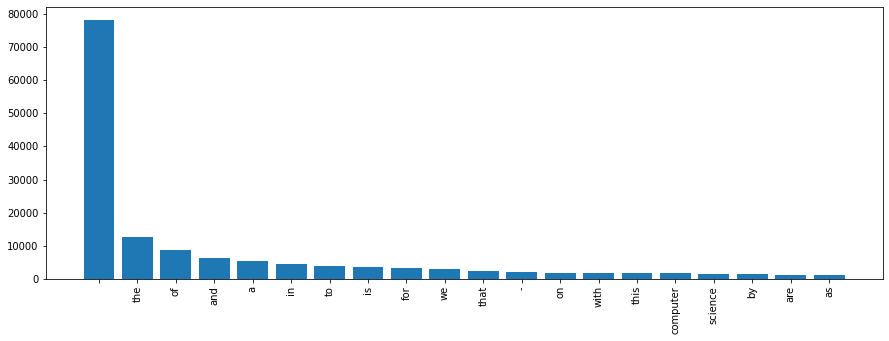

+--------------------------------------------------+--------------------------------------------------+
|                                            tokens|                                          features|
+--------------------------------------------------+--------------------------------------------------+
|[smooth, rényi, entropy, of, ergodic, quantum,...|(34806,[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,1...|
|[1, , , , colour, image, segmentation, by, the,...|(34806,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[analyzing, design, process, and, experiments, ...|(34806,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[1, , unequal, error, protection:, an, informat...|(34806,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,1...|
|[on, the, hitting, times, of, quantum, versus, ...|(34806,[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,17,1...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows

['', 'the', 'of', 'and', 'a', 'in', 'to

In [19]:
plot_word_count(tokenized_df, "tokens")
print_size_bow(tokenized_df, "tokens")

In [20]:
# Tokenization, option 2 tokenizer from spark nlp
documentAssembler = DocumentAssembler() \
     .setInputCol('content') \
     .setOutputCol('document')

tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('token')

finisher = Finisher() \
     .setInputCols(['token']) \
     .setCleanAnnotations(False)

pipeline = Pipeline() \
     .setStages([
           documentAssembler,
           tokenizer,
           finisher,
     ])
tokenized_df_snlp = pipeline.fit(files_df).transform(files_df)\
      .select("filename", "content", "finished_token")
tokenized_df_snlp.limit(10).toPandas()

filename  ...                                     finished_token
0  0704.3504.txt  ...  [Smooth, Rényi, Entropy, of, Ergodic, Quantum...
1  0710.0736.txt  ...  [1, Colour, Image, Segmentation, by, the, Vect...
2  0706.1402.txt  ...  [Analyzing, Design, Process, and, Experiments,...
3  0803.2570.txt  ...  [1, Unequal, Error, Protection, :, An, Informa...
4  0808.0084.txt  ...  [On, the, hitting, times, of, quantum, versus,...
5  0812.2709.txt  ...  [1, Variations, on, a, theme, by, Schalkwijk, ...
6  0811.2853.txt  ...  [Generating, Random, Networks, Without, Short,...
7  0811.1254.txt  ...  [arXiv:0811.1254v1, [math.CO], 8, Nov, 2008, C...
8  papers-dc.xml  ...  [2019-03-23T22:37:43Z, http://export.arxiv.org...

[9 rows x 3 columns]

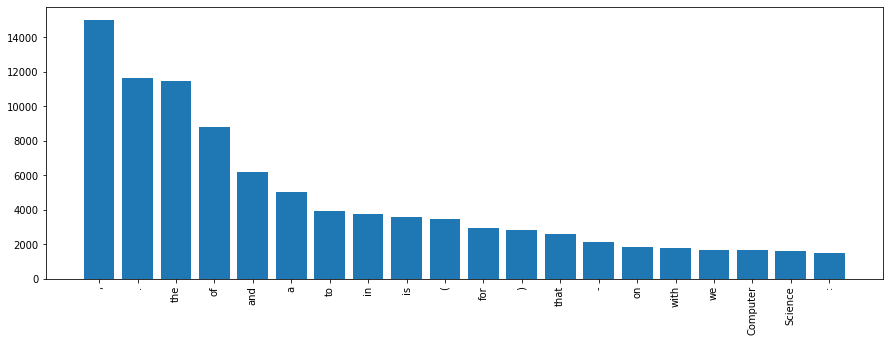

+--------------------------------------------------+--------------------------------------------------+
|                                    finished_token|                                          features|
+--------------------------------------------------+--------------------------------------------------+
|[Smooth, Rényi, Entropy, of, Ergodic, Quantum,...|(30027,[0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,1...|
|[1, Colour, Image, Segmentation, by, the, Vecto...|(30027,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[Analyzing, Design, Process, and, Experiments, ...|(30027,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[1, Unequal, Error, Protection, :, An, Informat...|(30027,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[On, the, hitting, times, of, quantum, versus, ...|(30027,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows

[',', '.', 'the', 'of', 'and', 'a', 'to

In [21]:
plot_word_count(tokenized_df_snlp, "finished_token")
print_size_bow(tokenized_df_snlp, "finished_token")

# Remove irrelevant tokens and lowercase

In [22]:
# Special character normalizer removal option 1 spark ml
# Remove irrelevant tokens and lowercase
normalized_text_df = tokenized_df.withColumn("normalized", explode("tokens"))\
            .withColumn("normalized", regexp_replace(col("normalized"), "[^A-Za-z0-9]", ""))\
            .withColumn("normalized", lower(col("normalized")))\
            .groupBy("filename").agg(collect_list("normalized").alias("normalized"))\
            .withColumn("normalized", array_remove("normalized", "")) # Delete void values
normalized_text_df.show(10, 100)            

+-------------+----------------------------------------------------------------------------------------------------+
|     filename|                                                                                          normalized|
+-------------+----------------------------------------------------------------------------------------------------+
|0706.1402.txt|[analyzing, design, process, and, experiments, on, the, anita, generic, tutoring, system, matthia...|
|papers-dc.xml|[20190323t223743z, httpexportarxivorgoai2, oaiarxivorg07043504, 20180213, cs, smooth, renyi, entr...|
|0710.0736.txt|[1, colour, image, segmentation, by, the, vectorvalued, allencahn, phasefield, model, a, multigri...|
|0811.1254.txt|[arxiv08111254v1, mathco, 8, nov, 2008, chapter, 1, coding, theory, and, algebraic, combinatorics...|
|0704.3504.txt|[smooth, renyi, entropy, of, ergodic, quantum, information, sources, berry, schoenmakers, jilles,...|
|0803.2570.txt|[1, unequal, error, protection, an, information, 

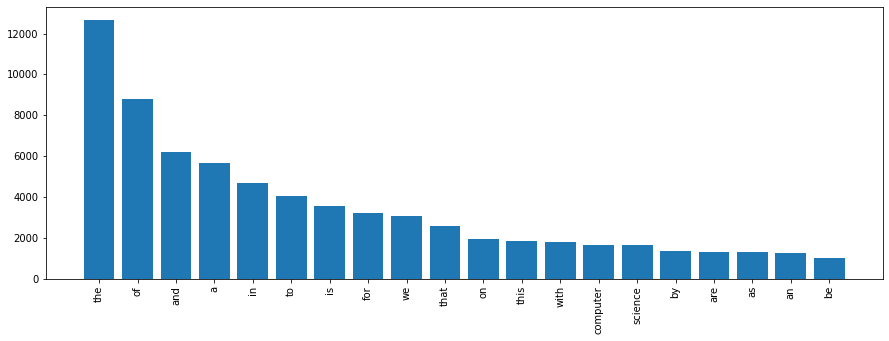

+--------------------------------------------------+--------------------------------------------------+
|                                        normalized|                                          features|
+--------------------------------------------------+--------------------------------------------------+
|[analyzing, design, process, and, experiments, ...|(24339,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[20190323t223743z, httpexportarxivorgoai2, oaia...|(24339,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[1, colour, image, segmentation, by, the, vecto...|(24339,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[arxiv08111254v1, mathco, 8, nov, 2008, chapter...|(24339,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[smooth, renyi, entropy, of, ergodic, quantum, ...|(24339,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows

['the', 'of', 'and', 'a', 'in', 'to', '

In [23]:
plot_word_count(normalized_text_df, "normalized")
print_size_bow(normalized_text_df, "normalized")

In [24]:
# Special character normalizer removal option 2 spark nlp
# Defaults to changing all words to lowercase and keep only alpha caracters
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
     .setInputCols(['token']) \
     .setOutputCol('normalized') \
     .setLowercase(True) \
     .setCleanupPatterns(["[^A-Za-z0-9]"])

# finisher converts tokens to human-readable output
finisher = Finisher() \
     .setInputCols(['normalized']) \
     .setCleanAnnotations(False)

pipeline = Pipeline() \
.setStages([
      documentAssembler,
      tokenizer,
      normalizer,
      finisher,
])
normalized_text_df_snlp = pipeline.fit(files_df).transform(files_df)\
      .select("filename", "token", "finished_normalized")
normalized_text_df_snlp.show(10, 80)

+-------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|     filename|                                                                           token|                                                             finished_normalized|
+-------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|0704.3504.txt|[[token, 0, 5, Smooth, [sentence -> 0], []], [token, 7, 12, Rényi, [sentence...|[smooth, renyi, entropy, of, ergodic, quantum, information, sources, berry, s...|
|0710.0736.txt|[[token, 0, 0, 1, [sentence -> 0], []], [token, 5, 10, Colour, [sentence -> 0...|[1, colour, image, segmentation, by, the, vectorvalued, allencahn, phasefield...|
|0706.1402.txt|[[token, 0, 8, Analyzing, [sentence -> 0], []], [token, 10, 15, Design, [sent...|[analyzing, de

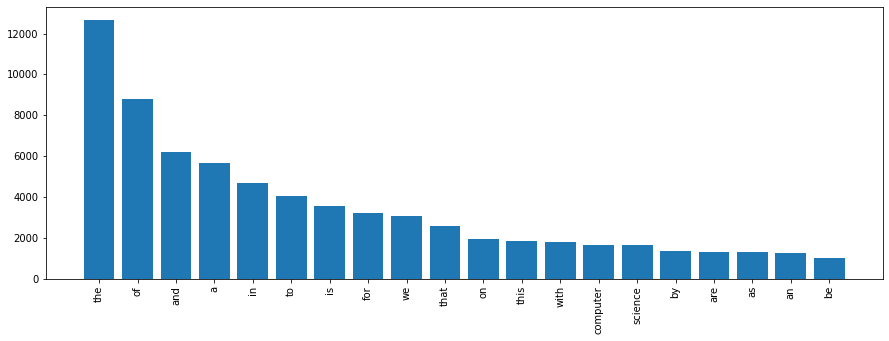

+--------------------------------------------------+--------------------------------------------------+
|                               finished_normalized|                                          features|
+--------------------------------------------------+--------------------------------------------------+
|[smooth, renyi, entropy, of, ergodic, quantum, ...|(24339,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[1, colour, image, segmentation, by, the, vecto...|(24339,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[analyzing, design, process, and, experiments, ...|(24339,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[1, unequal, error, protection, an, information...|(24339,[0,1,2,3,4,5,6,7,8,9,10,11,12,15,16,17,1...|
|[on, the, hitting, times, of, quantum, versus, ...|(24339,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows

['the', 'of', 'and', 'a', 'in', 'to', '

In [25]:
plot_word_count(normalized_text_df_snlp, "finished_normalized")
print_size_bow(normalized_text_df_snlp, "finished_normalized")

## Stopword removal

In [26]:
# Stopword removal option 1 pyspark.ml
stopword_removal=StopWordsRemover(inputCol='normalized', outputCol='refined_tokens')
refined_text_df=stopword_removal.transform(normalized_text_df)
refined_text_df.select("filename","normalized", "refined_tokens").show(10, 60)

+-------------+------------------------------------------------------------+------------------------------------------------------------+
|     filename|                                                  normalized|                                              refined_tokens|
+-------------+------------------------------------------------------------+------------------------------------------------------------+
|0706.1402.txt|[analyzing, design, process, and, experiments, on, the, a...|[analyzing, design, process, experiments, anita, generic,...|
|papers-dc.xml|[20190323t223743z, httpexportarxivorgoai2, oaiarxivorg070...|[20190323t223743z, httpexportarxivorgoai2, oaiarxivorg070...|
|0710.0736.txt|[1, colour, image, segmentation, by, the, vectorvalued, a...|[1, colour, image, segmentation, vectorvalued, allencahn,...|
|0811.1254.txt|[arxiv08111254v1, mathco, 8, nov, 2008, chapter, 1, codin...|[arxiv08111254v1, mathco, 8, nov, 2008, chapter, 1, codin...|
|0704.3504.txt|[smooth, renyi, ent

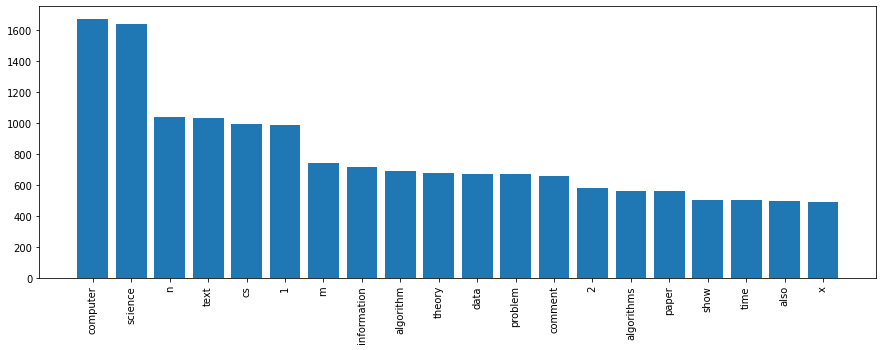

+--------------------------------------------------+--------------------------------------------------+
|                                    refined_tokens|                                          features|
+--------------------------------------------------+--------------------------------------------------+
|[analyzing, design, process, experiments, anita...|(24217,[0,1,2,3,5,6,7,10,11,13,14,15,16,17,18,2...|
|[20190323t223743z, httpexportarxivorgoai2, oaia...|(24217,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,1...|
|[1, colour, image, segmentation, vectorvalued, ...|(24217,[0,1,2,5,6,7,8,9,10,11,13,15,16,17,18,19...|
|[arxiv08111254v1, mathco, 8, nov, 2008, chapter...|(24217,[0,1,2,5,6,7,8,9,10,11,13,14,16,18,19,20...|
|[smooth, renyi, entropy, ergodic, quantum, info...|(24217,[0,1,2,5,6,7,9,11,13,15,16,18,19,20,21,2...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows

['computer', 'science', 'n', 'text', 'c

In [27]:
plot_word_count(refined_text_df, "refined_tokens")
print_size_bow(refined_text_df, "refined_tokens")

In [28]:
# Stopword removal option 2 spark nlp with help of nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
eng_stopwords = stopwords.words('english')

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['normalized']) \
     .setOutputCol('clean_words') \
     .setCaseSensitive(False) \
     .setStopWords(eng_stopwords)
# finisher converts tokens to human-readable output
finisher = Finisher() \
     .setInputCols(['clean_words']) \
     .setCleanAnnotations(False)

pipeline = Pipeline() \
.setStages([
      documentAssembler,
      tokenizer,
      normalizer,
      stopwords_cleaner,
      finisher,
])
refined_text_df_snlp = pipeline.fit(files_df).transform(files_df)\
      .select("filename", "normalized", "finished_clean_words")
refined_text_df_snlp.show(10, 60)

+-------------+------------------------------------------------------------+------------------------------------------------------------+
|     filename|                                                  normalized|                                        finished_clean_words|
+-------------+------------------------------------------------------------+------------------------------------------------------------+
|0704.3504.txt|[[token, 0, 5, smooth, [sentence -> 0], []], [token, 7, 1...|[smooth, renyi, entropy, ergodic, quantum, information, s...|
|0710.0736.txt|[[token, 0, 0, 1, [sentence -> 0], []], [token, 5, 10, co...|[1, colour, image, segmentation, vectorvalued, allencahn,...|
|0706.1402.txt|[[token, 0, 8, analyzing, [sentence -> 0], []], [token, 1...|[analyzing, design, process, experiments, anita, generic,...|
|0803.2570.txt|[[token, 0, 0, 1, [sentence -> 0], []], [token, 3, 9, une...|[1, unequal, error, protection, information, theoretic, p...|
|0808.0084.txt|[[token, 0, 1, on, 

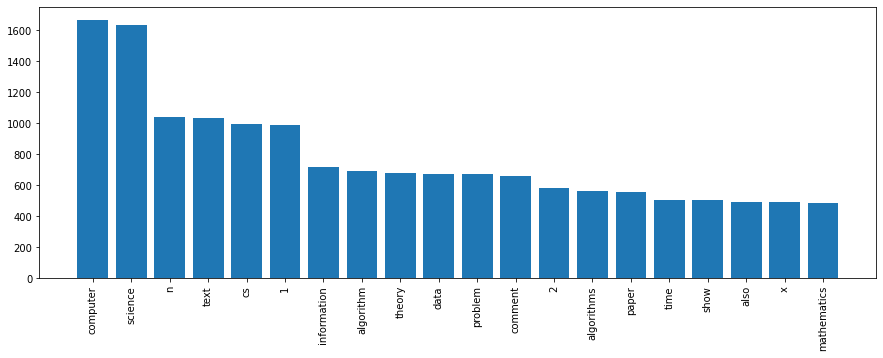

+--------------------------------------------------+--------------------------------------------------+
|                              finished_clean_words|                                          features|
+--------------------------------------------------+--------------------------------------------------+
|[smooth, renyi, entropy, ergodic, quantum, info...|(24213,[0,1,2,5,6,8,10,12,14,16,17,18,19,20,24,...|
|[1, colour, image, segmentation, vectorvalued, ...|(24213,[0,1,2,5,6,7,8,9,10,12,14,15,16,17,18,19...|
|[analyzing, design, process, experiments, anita...|(24213,[0,1,2,3,5,6,9,10,12,13,14,15,16,17,20,2...|
|[1, unequal, error, protection, information, th...|(24213,[2,3,5,6,7,8,9,10,12,14,15,16,17,18,20,2...|
|[hitting, times, quantum, versus, random, walks...|(24213,[0,1,2,5,6,7,8,9,12,13,14,15,16,17,18,20...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows

['computer', 'science', 'n', 'text', 'c

In [30]:
plot_word_count(refined_text_df_snlp, "finished_clean_words")
print_size_bow(refined_text_df_snlp, "finished_clean_words")

## Lemmatizer

In [31]:
# Lemmatizer only found with spark nlp

# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)
lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['clean_words']) \
     .setOutputCol('lemma')

# finisher converts tokens to human-readable output
finisher = Finisher() \
     .setInputCols(['lemma']) \
     .setCleanAnnotations(False)

pipeline = Pipeline() \
.setStages([
      documentAssembler,
      tokenizer,
      normalizer,
      stopwords_cleaner,
      lemmatizer,
      finisher,
])

lemma_text_df_snlp = pipeline.fit(files_df).transform(files_df)\
      .select("filename", "clean_words", "finished_lemma")
lemma_text_df_snlp.show(10, 80)  

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
+-------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|     filename|                                                                     clean_words|                                                                  finished_lemma|
+-------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|0704.3504.txt|[[token, 0, 5, smooth, [sentence -> 0], []], [token, 7, 11, renyi, [sentence ...|[smooth, renyi, entropy, ergodic, quantum, information, source, berry, schoen...|
|0710.0736.txt|[[token, 0, 0, 1, [sentence -> 0], []], [token, 5, 10, colour, [sentence -> 0...|[1, colour, image, segmentation, vectorvalued, allencahn, phasefield, model, ...|
|0706.1402.

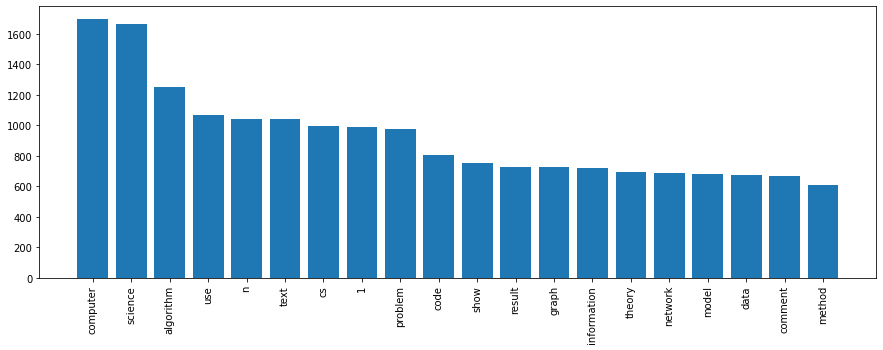

+--------------------------------------------------+--------------------------------------------------+
|                                    finished_lemma|                                          features|
+--------------------------------------------------+--------------------------------------------------+
|[smooth, renyi, entropy, ergodic, quantum, info...|(21527,[0,1,3,4,7,10,11,13,14,17,20,22,23,24,25...|
|[1, colour, image, segmentation, vectorvalued, ...|(21527,[0,1,2,3,4,7,8,10,11,13,14,16,17,19,20,2...|
|[analyze, design, process, experiment, anita, g...|(21527,[0,1,2,3,4,5,7,8,9,10,11,13,14,15,16,17,...|
|[1, unequal, error, protection, information, th...|(21527,[2,3,4,5,7,8,9,10,11,13,14,15,16,17,19,2...|
|[hit, time, quantum, versus, random, walk, arxi...|(21527,[0,1,2,3,4,7,8,10,11,12,13,14,16,21,22,2...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows

['computer', 'science', 'algorithm', 'u

In [32]:
plot_word_count(lemma_text_df_snlp, "finished_lemma")
print_size_bow(lemma_text_df_snlp, "finished_lemma")

## Stemming

In [33]:
# Stemming only found with spark nlp

stemmer = Stemmer() \
     .setLanguage("English") \
     .setInputCols(['lemma']) \
     .setOutputCol('stem')

# finisher converts tokens to human-readable output
finisher = Finisher() \
     .setInputCols(['stem']) \
     .setCleanAnnotations(False)

pipeline = Pipeline() \
.setStages([
      documentAssembler,
      tokenizer,
      normalizer,
      stopwords_cleaner,
      lemmatizer,
      stemmer,
      finisher,
])

stem_text_df_snlp = pipeline.fit(files_df).transform(files_df)\
      .select("filename", "lemma", "finished_stem")
stem_text_df_snlp.show(10, 80)  

+-------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|     filename|                                                                           lemma|                                                                   finished_stem|
+-------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|0704.3504.txt|[[token, 0, 5, smooth, [sentence -> 0], []], [token, 7, 11, renyi, [sentence ...|[smooth, renyi, entropi, ergod, quantum, inform, sourc, berri, schoenmak, jil...|
|0710.0736.txt|[[token, 0, 0, 1, [sentence -> 0], []], [token, 5, 10, colour, [sentence -> 0...|[1, colour, imag, segment, vectorvalu, allencahn, phasefield, model, multigri...|
|0706.1402.txt|[[token, 0, 8, analyze, [sentence -> 0], []], [token, 10, 15, design, [senten...|[analyz, desig

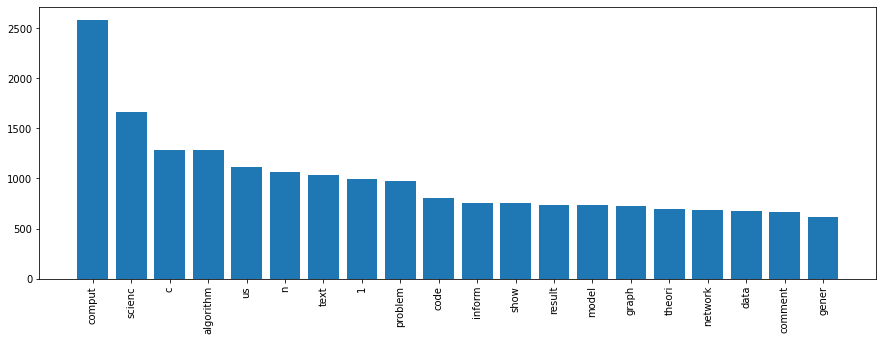

+--------------------------------------------------+--------------------------------------------------+
|                                     finished_stem|                                          features|
+--------------------------------------------------+--------------------------------------------------+
|[smooth, renyi, entropi, ergod, quantum, inform...|(19758,[0,1,2,4,5,7,10,11,13,15,17,19,21,23,24,...|
|[1, colour, imag, segment, vectorvalu, allencah...|(19758,[0,1,2,3,4,5,7,8,10,11,12,13,15,17,19,20...|
|[analyz, design, process, experi, anita, gener,...|(19758,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,1...|
|[1, unequ, error, protect, inform, theoret, per...|(19758,[2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,19...|
|[hit, time, quantum, versu, random, walk, arxiv...|(19758,[0,1,2,3,4,5,7,8,10,11,12,13,14,15,19,22...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows

['comput', 'scienc', 'c', 'algorithm', 

In [34]:
plot_word_count(stem_text_df_snlp, "finished_stem")
print_size_bow(stem_text_df_snlp, "finished_stem")

## Ngram

In [35]:
ngram = NGram(n=2, inputCol="finished_stem", outputCol="2grams")
bigram_df = ngram.transform(stem_text_df_snlp)
bigram_df.select("finished_stem", "2grams").show(5, 100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                       finished_stem|                                                                                              2grams|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[smooth, renyi, entropi, ergod, quantum, inform, sourc, berri, schoenmak, jill, tjoelker, arxiv07...|[smooth renyi, renyi entropi, entropi ergod, ergod quantum, quantum inform, inform sourc, sourc b...|
|[1, colour, imag, segment, vectorvalu, allencahn, phasefield, model, multigrid, solut, arxiv07100...|[1 colour, colour imag, imag segment, segment vectorvalu, vectorvalu allencahn, al

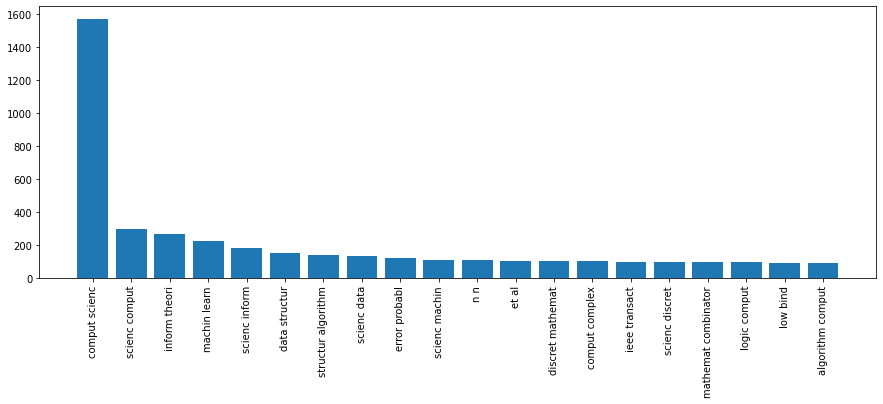

+--------------------------------------------------+--------------------------------------------------+
|                                            2grams|                                          features|
+--------------------------------------------------+--------------------------------------------------+
|[smooth renyi, renyi entropi, entropi ergod, er...|(113789,[0,2,10,18,26,29,38,45,46,55,66,76,88,1...|
|[1 colour, colour imag, imag segment, segment v...|(113789,[0,10,12,14,23,27,29,32,45,55,66,67,73,...|
|[analyz design, design process, process experi,...|(113789,[0,5,56,63,74,85,177,200,239,259,306,35...|
|[1 unequ, unequ error, error protect, protect i...|(113789,[2,8,10,12,14,18,26,27,28,29,31,37,38,4...|
|[hit time, time quantum, quantum versu, versu r...|(113789,[0,10,12,20,27,29,38,43,44,45,52,53,55,...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows

['comput scienc', 'scienc comput', 'inf

In [36]:
plot_word_count(bigram_df, "2grams")
print_size_bow(bigram_df, "2grams")

In [38]:
ngram = NGram(n=3, inputCol="finished_stem", outputCol="3grams")
trigram_df = ngram.transform(stem_text_df_snlp)
trigram_df.select("finished_stem", "3grams").show(5, 100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                       finished_stem|                                                                                              3grams|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[smooth, renyi, entropi, ergod, quantum, inform, sourc, berri, schoenmak, jill, tjoelker, arxiv07...|[smooth renyi entropi, renyi entropi ergod, entropi ergod quantum, ergod quantum inform, quantum ...|
|[1, colour, imag, segment, vectorvalu, allencahn, phasefield, model, multigrid, solut, arxiv07100...|[1 colour imag, colour imag segment, imag segment vectorvalu, segment vectorvalu a

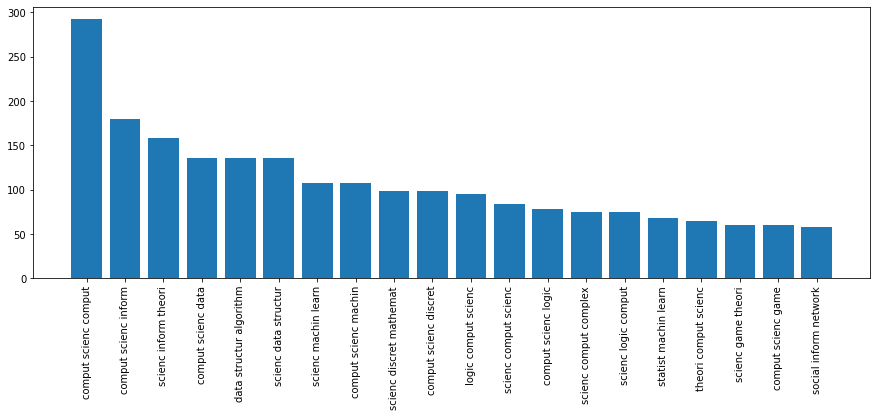

+--------------------------------------------------+--------------------------------------------------+
|                                            3grams|                                          features|
+--------------------------------------------------+--------------------------------------------------+
|[smooth renyi entropi, renyi entropi ergod, ent...|(147546,[73,86,87,191,294,325,327,380,396,427,4...|
|[1 colour imag, colour imag segment, imag segme...|(147546,[165,190,246,248,270,295,311,358,367,37...|
|[analyz design process, design process experi, ...|(147546,[215,488,513,651,678,706,730,785,847,86...|
|[1 unequ error, unequ error protect, error prot...|(147546,[44,46,60,68,69,84,86,105,106,119,120,1...|
|[hit time quantum, time quantum versu, quantum ...|(147546,[103,109,180,191,202,257,264,280,324,32...|
+--------------------------------------------------+--------------------------------------------------+
only showing top 5 rows

147546


In [39]:
plot_word_count(trigram_df, "3grams")
print_size_bow(trigram_df, "3grams", print_bow=False)

## Representation

In [76]:
# TF
countVec=CountVectorizer(inputCol='finished_stem', outputCol='features')
countVec =countVec.fit(stem_text_df_snlp)
cv_df=countVec.transform(stem_text_df_snlp)
cv_df.select(['filename','features']).show(4,False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [41]:
hashingTF = HashingTF(inputCol="finished_stem", outputCol="rawFeatures", numFeatures=2**12)
featurizedData = hashingTF.transform(stem_text_df_snlp)
featurizedData.show(4)

+-------------+--------------------+--------------------+--------------------+
|     filename|               lemma|       finished_stem|         rawFeatures|
+-------------+--------------------+--------------------+--------------------+
|0704.3504.txt|[[token, 0, 5, sm...|[smooth, renyi, e...|(4096,[12,26,34,3...|
|0710.0736.txt|[[token, 0, 0, 1,...|[1, colour, imag,...|(4096,[2,12,15,25...|
|0706.1402.txt|[[token, 0, 8, an...|[analyz, design, ...|(4096,[3,8,10,12,...|
|0803.2570.txt|[[token, 0, 0, 1,...|[1, unequ, error,...|(4096,[3,8,10,12,...|
+-------------+--------------------+--------------------+--------------------+
only showing top 4 rows



In [42]:
# Hasting tf-IDF

hashingTF = HashingTF(inputCol="finished_stem", outputCol="rawFeatures", numFeatures=2**12)
featurizedData = hashingTF.transform(stem_text_df_snlp)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
rescaledData.select("filename", "features").show(10, False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [43]:
# Word2Vec
word2Vec = Word2Vec(vectorSize=300, minCount=0, inputCol="finished_stem", outputCol="result")
print(word2Vec.explainParams())
model = word2Vec.fit(stem_text_df_snlp)
result = model.transform(stem_text_df_snlp)
result.select("filename", "result").show(10, False)

inputCol: input column name. (current: finished_stem)
maxIter: max number of iterations (>= 0). (default: 1)
maxSentenceLength: Maximum length (in words) of each sentence in the input data. Any sentence longer than this threshold will be divided into chunks up to the size. (default: 1000)
minCount: the minimum number of times a token must appear to be included in the word2vec model's vocabulary (default: 5, current: 0)
numPartitions: number of partitions for sentences of words (default: 1)
outputCol: output column name. (default: Word2Vec_b88ff10db7a6__output, current: result)
seed: random seed. (default: 5427304673178173942)
stepSize: Step size to be used for each iteration of optimization (>= 0). (default: 0.025)
vectorSize: the dimension of codes after transforming from words (default: 100, current: 300)
windowSize: the window size (context words from [-window, window]). Default value is 5 (default: 5)
+-------------+------------------------------------------------------------------

In [44]:
result.select("filename", "result").show(10, False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Save and load models

In [77]:
tfModelPath = path_out + "/tf-model"
countVec.write().overwrite().save(tfModelPath)
countVecLoadedModel = CountVectorizerModel.load(tfModelPath)
countVecLoadedModel.transform(stem_text_df_snlp).select(['filename','features']).show(4,False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [73]:
idfModelPath = path_out + "/idf-model"
idfModel.write().overwrite().save(idfModelPath)
idfLoadedModel = IDFModel.load(idfModelPath)
idfLoadedModel.transform(featurizedData).select("filename", "features").show(10, False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [74]:
word2vecModelPath = path_out + "/word2vec-model"
model.write().overwrite().save(word2vecModelPath)
word2vecLoadedModel = Word2VecModel.load(word2vecModelPath)
word2vecLoadedModel.transform(stem_text_df_snlp).select("filename", "result").show(10, False)

+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------